In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
from scipy.optimize import least_squares, curve_fit


sns.set_theme(context="paper", style="whitegrid", font_scale=1.4,
              rc = {'xtick.bottom': True, 'xtick.top': True, 'ytick.left': True, 'ytick.right': True,
                   'axes.grid': True,  'axes.edgecolor': '.15'})

In [2]:
df_mlcs = pd.read_csv("Table5.csv",index_col=0)
df_template = pd.read_csv("Table6.csv",index_col=0)

In [3]:
c = 300000 # km/s

In [4]:
def integrand(z, OmegaM, OmegaLambda):
    return np.power((1+z)**2 * (1+OmegaM*z) - z*(2+z)*OmegaLambda,-1/2)

In [5]:
def DL(z, OmegaM, OmegaLambda):
 
    zmin = 0
    zmax = z
    int_val, _ = quad(integrand, zmin, zmax, args=(OmegaM, OmegaLambda))
    
    OmegaK = 1 - OmegaM - OmegaLambda
    
    if OmegaK>=0:
        sinn = np.sinh
    else:
        sinn = np.sin
        
    DL_val = 300000/65.2 * (1+z) * np.power(np.abs(OmegaK),-1/2)*\
    sinn(np.power(np.abs(OmegaK),1/2) * int_val)
    
    distmod = 5*np.log10(DL_val) + 25
    
    return distmod

In [6]:
# Test
DL(z=0.43, OmegaM=0.2, OmegaLambda=0)

41.85140414633088

In [7]:
# Wrapper function
def DL_zarr(zarr, OmegaM, OmegaLambda):
    return np.array([DL(z, OmegaM, OmegaLambda) for z in zarr])   

In [8]:
# Test
DL_zarr(zarr=[0.43,0.44], OmegaM=0.2, OmegaLambda=0)

array([41.85140415, 41.90889102])

In [9]:
H_mlcs = 65.2 # km s^-1 Mpc^-1

In [10]:
z_inp = np.linspace(0.01, 1.1, num=150)

In [10]:
# model 1
y_pred1 = np.array([DL(c=c, H0=H_mlcs, z=z, OmegaM=0.24, OmegaLambda=0.75999) for z in z_inp])

# model 2
y_pred2 = np.array([DL(c=c, H0=H_mlcs, z=z, OmegaM=0.2, OmegaLambda=0) for z in z_inp])

# model 3
y_pred3 = np.array([DL(c=c, H0=H_mlcs, z=z, OmegaM=0.99999, OmegaLambda=0) for z in z_inp])

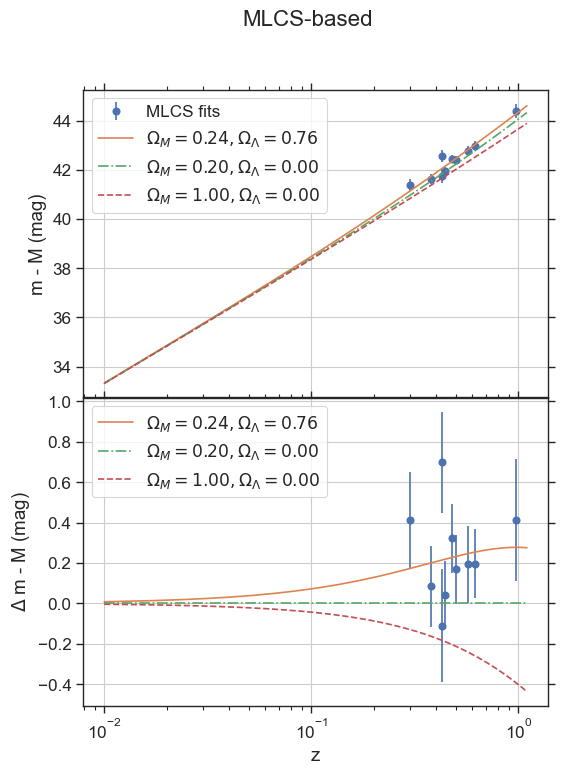

In [11]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(6,8), sharex=True)

ax0.errorbar(x=df_mlcs["z"],y=df_mlcs["mu0"],yerr=df_mlcs["err_mu0"],fmt="o", label="MLCS fits")
ax0.errorbar(x=z_inp,y=y_pred1,fmt="-", label="$\Omega_M=0.24,\Omega_\Lambda=0.76$")
ax0.errorbar(x=z_inp,y=y_pred2,fmt="-.", label="$\Omega_M=0.20,\Omega_\Lambda=0.00$")
ax0.errorbar(x=z_inp,y=y_pred3,fmt="--", label="$\Omega_M=1.00,\Omega_\Lambda=0.00$")

ax0.set_ylabel("m - M (mag)")
ax0.legend()


y_data_fit = np.array([DL(c=c, H0=H_mlcs, z=z, OmegaM=0.2, OmegaLambda=0) for z in df_mlcs["z"]])
y_diff = df_mlcs["mu0"] - y_data_fit
ax1.errorbar(x=df_mlcs["z"],y=y_diff,yerr=df_mlcs["err_mu0"],fmt="o")
ax1.errorbar(x=z_inp,y=y_pred1 - y_pred2,fmt="-", label="$\Omega_M=0.24,\Omega_\Lambda=0.76$")
ax1.errorbar(x=z_inp,y=y_pred2 - y_pred2,fmt="-.", label="$\Omega_M=0.20,\Omega_\Lambda=0.00$")
ax1.errorbar(x=z_inp,y=y_pred3 - y_pred2,fmt="--", label="$\Omega_M=1.00,\Omega_\Lambda=0.00$")
ax1.set_ylabel("$\Delta$ m - M (mag)")
ax1.set_xscale("log")
ax1.set_xlabel("z")
ax1.legend()
plt.suptitle("MLCS-based")
plt.subplots_adjust(hspace=0.001)
plt.show()

In [11]:
pout, pcov = curve_fit(
    f=DL_zarr,
    xdata=df_mlcs["z"].to_numpy(),
    ydata=df_mlcs["mu0"].to_numpy(),
    sigma=df_mlcs["err_mu0"].to_numpy(),
)

In [12]:
omega_m, omega_lambda = pout
print(f"ΩM = {omega_m:.3f}, ΩΛ = {omega_lambda:.3f}")

ΩM = 0.068, ΩΛ = 0.535


### 1. MLCS

### 2. Template

In [12]:
H_template = 63.8 # km s^-1 Mpc^-1

In [13]:
z_inp = np.linspace(0.01, 1.1, num=150)

In [14]:
# model 1
y_pred1 = np.array([DL(c=c, H0=H_template, z=z, OmegaM=0.24, OmegaLambda=0.75999) for z in z_inp])

# model 2
y_pred2 = np.array([DL(c=c, H0=H_template, z=z, OmegaM=0.2, OmegaLambda=0) for z in z_inp])

# model 3
y_pred3 = np.array([DL(c=c, H0=H_template, z=z, OmegaM=0.99999, OmegaLambda=0) for z in z_inp])

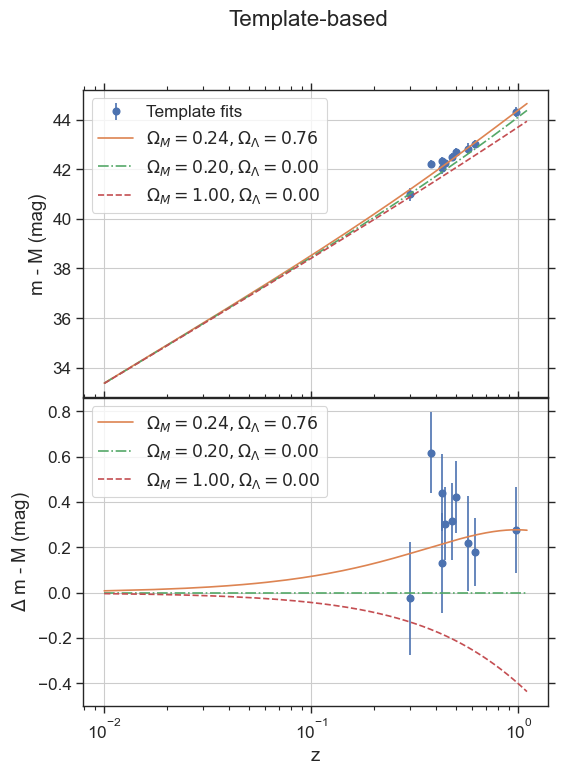

In [15]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(6,8), sharex=True)

ax0.errorbar(x=df_template["z"],y=df_template["mu0"],yerr=df_template["err_mu0"],fmt="o", label="Template fits")
ax0.errorbar(x=z_inp,y=y_pred1,fmt="-", label="$\Omega_M=0.24,\Omega_\Lambda=0.76$")
ax0.errorbar(x=z_inp,y=y_pred2,fmt="-.", label="$\Omega_M=0.20,\Omega_\Lambda=0.00$")
ax0.errorbar(x=z_inp,y=y_pred3,fmt="--", label="$\Omega_M=1.00,\Omega_\Lambda=0.00$")

ax0.set_ylabel("m - M (mag)")
ax0.legend()


y_data_fit = np.array([DL(c=c, H0=H_template, z=z, OmegaM=0.2, OmegaLambda=0) for z in df_template["z"]])
y_diff = df_template["mu0"] - y_data_fit
ax1.errorbar(x=df_template["z"],y=y_diff,yerr=df_template["err_mu0"],fmt="o")
ax1.errorbar(x=z_inp,y=y_pred1 - y_pred2,fmt="-", label="$\Omega_M=0.24,\Omega_\Lambda=0.76$")
ax1.errorbar(x=z_inp,y=y_pred2 - y_pred2,fmt="-.", label="$\Omega_M=0.20,\Omega_\Lambda=0.00$")
ax1.errorbar(x=z_inp,y=y_pred3 - y_pred2,fmt="--", label="$\Omega_M=1.00,\Omega_\Lambda=0.00$")
ax1.set_ylabel("$\Delta$ m - M (mag)")
ax1.set_xscale("log")
ax1.set_xlabel("z")
ax1.legend()
plt.suptitle("Template-based")
plt.subplots_adjust(hspace=0.001)
plt.show()

In [18]:
def DL(z, OmegaM, OmegaLambda):
 
    zmin = 0
    zmax = z
    int_val, _ = quad(integrand, zmin, zmax, args=(OmegaM, OmegaLambda))
    
    OmegaK = 1 - OmegaM - OmegaLambda
    
    if OmegaK>=0:
        sinn = np.sinh
    else:
        sinn = np.sin
        
    DL_val = 300000/63.8 * (1+z) * np.power(np.abs(OmegaK),-1/2)*\
    sinn(np.power(np.abs(OmegaK),1/2) * int_val)
    
    distmod = 5*np.log10(DL_val) + 25
    
    return distmod

In [19]:
# Wrapper function
def DL_zarr(zarr, OmegaM, OmegaLambda):
    return np.array([DL(z, OmegaM, OmegaLambda) for z in zarr])   

In [20]:
# Test
DL_zarr(zarr=[0.43,0.44], OmegaM=0.2, OmegaLambda=0)

array([41.89853873, 41.9560256 ])

In [21]:
pout, pcov = curve_fit(
    f=DL_zarr,
    xdata=df_template["z"].to_numpy(),
    ydata=df_template["mu0"].to_numpy(),
    sigma=df_template["err_mu0"].to_numpy(),
)

In [22]:
omega_m, omega_lambda = pout
print(f"ΩM = {omega_m:.3f}, ΩΛ = {omega_lambda:.3f}")

ΩM = 0.639, ΩΛ = 1.429
